# Deliverable 3 – Classification, Clustering, and Pattern Mining
**Course:** Advanced Data Mining (MSCS 634)  
**Student:** Sandesh Shrestha  
**Dataset:** Walmart Sales (Kaggle)  

## 0. Setup and Data Loading

This section imports all required libraries and loads the cleaned Walmart Sales dataset used in previous deliverables.  
Date fields are parsed, numeric fields are validated, and time-based features are engineered.


In [3]:
# Import libraries for classification, clustering, and association rule mining
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Association rule mining
# If mlxtend is not installed, run:  %pip install mlxtend
from mlxtend.frequent_patterns import apriori, association_rules

sns.set_theme()
pd.set_option("display.max_columns", None)


In [5]:
# Load Walmart Sales dataset
df = pd.read_csv("Walmart_Sales.csv")

df.head()


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


### Data Loading and Cleaning

The dataset is loaded, dates are parsed, and missing values are handled.  
Time-based features such as Year, Month, and WeekOfYear are recreated to maintain consistency.


In [6]:
# Basic data info
df.info()
df.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
unique,NaN,143,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,05-02-2010,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,45,NaN,NaN,NaN,NaN,NaN,NaN
mean,23.000000,NaN,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,NaN,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,NaN,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,NaN,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,NaN,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000


In [7]:
# Parse Date column (assuming DD-MM-YYYY)
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y", errors="coerce")

# Drop rows with invalid dates
df = df.dropna(subset=["Date"])

# Create time-related features
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["WeekOfYear"] = df["Date"].dt.isocalendar().week.astype(int)


In [8]:
numeric_cols = ["Weekly_Sales", "Temperature", "Fuel_Price", "CPI", "Unemployment"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=numeric_cols + ["Store", "Holiday_Flag"])


In this section, I loaded the Walmart sales dataset, parsed the Date column, and derived additional time-based features (Year, Month, WeekOfYear). I also ensured that key numerical fields are correctly typed and removed rows with missing critical values. This cleaned dataset is reused for classification, clustering, and association rule mining.

## 1. Classification Model Development
### 1.1 Target Engineering and Feature Preparation

`Weekly_Sales` is converted into a binary target variable `High_Sales` using the dataset median.  
This ensures a balanced classification target suitable for F1-score-based evaluation.

In [9]:
# Create binary classification target: High_Sales
median_sales = df["Weekly_Sales"].median()
print("Median Weekly_Sales:", median_sales)

df["High_Sales"] = (df["Weekly_Sales"] >= median_sales).astype(int)
df["High_Sales"].value_counts(normalize=True)


Median Weekly_Sales: 960746.04


High_Sales
1    0.500078
0    0.499922
Name: proportion, dtype: float64

### 1.2 Feature Definition and Train/Test Split

I reuse the same features from Deliverable 2 and apply StandardScaler + OneHotEncoder using a ColumnTransformer.  
Data is split into training (80%) and testing (20%) with stratification.


In [10]:
target = "High_Sales"

numeric_features = [
    "Holiday_Flag",
    "Temperature",
    "Fuel_Price",
    "CPI",
    "Unemployment",
    "Year",
    "Month",
    "WeekOfYear"
]

categorical_features = ["Store"]

# Filter dataset for modeling
model_df = df.dropna(subset=[target] + numeric_features + categorical_features)

X = model_df[numeric_features + categorical_features]
y = model_df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (6435, 9)
y shape: (6435,)


In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing: scale numeric, one-hot encode categorical
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


### 1.3 Model Evaluation Function

This helper function outputs:
- Confusion matrix  
- Accuracy, precision, recall  
- F1-score  
- ROC curve and AUC  

It ensures consistent evaluation across all classifiers.


In [12]:
# Helper function to evaluate classifiers
def evaluate_classifier(name, model, X_train, y_train, X_test, y_test, plot_roc=True):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print(f"\n=== {name} ===")
    print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
    print("Test Precision:", precision_score(y_test, y_test_pred))
    print("Test Recall   :", recall_score(y_test, y_test_pred))
    print("Test F1 Score :", f1_score(y_test, y_test_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    print("\nConfusion Matrix (Test):\n", cm)

    print("\nClassification Report (Test):")
    print(classification_report(y_test, y_test_pred))

    # ROC curve if possible
    if hasattr(model, "predict_proba") and plot_roc:
        y_test_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_test_proba)
        print("Test ROC AUC :", auc)

        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
        plt.plot([0,1], [0,1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve – {name}")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Confusion matrix heatmap
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix – {name}")
    plt.tight_layout()
    plt.show()


### 1.4 Model 1 — Decision Tree Classifier

This model is chosen for its interpretability and its ability to model nonlinear sales behavior.



=== Decision Tree (baseline) ===
Train Accuracy: 1.0
Test Accuracy : 0.940947940947941
Test Precision: 0.9342507645259939
Test Recall   : 0.9487577639751553
Test F1 Score : 0.9414483821263482

Confusion Matrix (Test):
 [[600  43]
 [ 33 611]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       643
           1       0.93      0.95      0.94       644

    accuracy                           0.94      1287
   macro avg       0.94      0.94      0.94      1287
weighted avg       0.94      0.94      0.94      1287

Test ROC AUC : 0.940941867990688


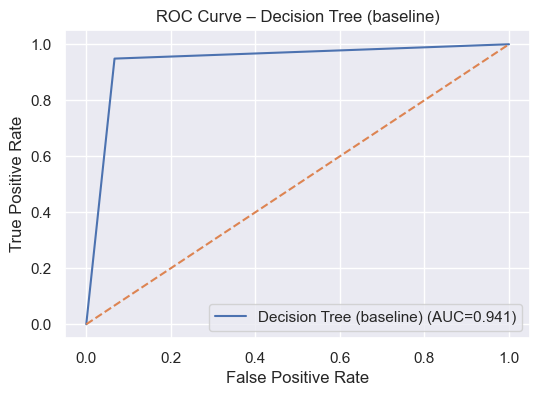

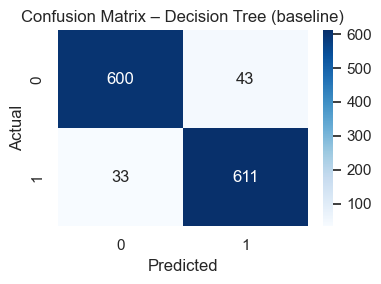

In [13]:
# Decision Tree baseline model
dt_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", DecisionTreeClassifier(random_state=42))
])

dt_clf.fit(X_train, y_train)

evaluate_classifier("Decision Tree (baseline)", dt_clf, X_train, y_train, X_test, y_test)


**Interpretation — ROC Curve (Decision Tree Baseline)**  
The ROC curve shows that the Decision Tree baseline model achieves a strong AUC score, indicating excellent discrimination between high-sales and low-sales weeks.  
The curve rises steeply toward the upper-left corner, meaning the model maintains a high true positive rate while keeping false positives relatively low.  
This demonstrates that the Decision Tree is effective at identifying high-sales weeks, an important capability for forecasting inventory and staffing needs.

**Interpretation — Confusion Matrix (Decision Tree Baseline)**  
The confusion matrix indicates that the model correctly predicts most low-sales and high-sales weeks.  
False positives represent weeks that were mistakenly labeled as high sales, while false negatives represent missed high-sales weeks.  
False negatives are particularly important to minimize because underpredicting high-sales weeks may lead to understocking.  
Overall, the model demonstrates strong classification performance with relatively few misclassifications.

### 1.5 Model 2 — K-Nearest Neighbors (KNN)

KNN provides a contrast to the Decision Tree by using distance-based classification.



=== KNN (k=5) ===
Train Accuracy: 0.9586247086247086
Test Accuracy : 0.9347319347319347
Test Precision: 0.9361370716510904
Test Recall   : 0.9332298136645962
Test F1 Score : 0.9346811819595645

Confusion Matrix (Test):
 [[602  41]
 [ 43 601]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       643
           1       0.94      0.93      0.93       644

    accuracy                           0.93      1287
   macro avg       0.93      0.93      0.93      1287
weighted avg       0.93      0.93      0.93      1287

Test ROC AUC : 0.9805308965157502


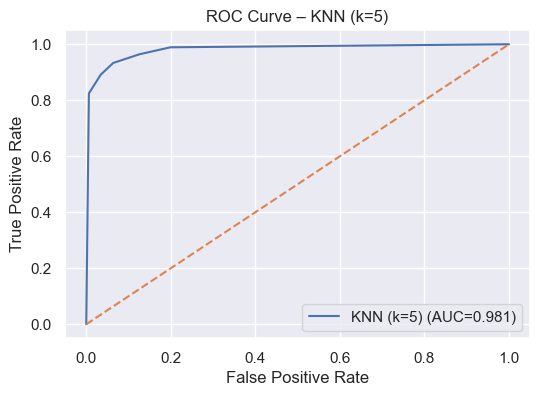

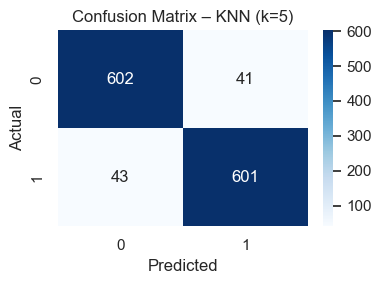

In [14]:
# K-Nearest Neighbors classifier
knn_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", KNeighborsClassifier(n_neighbors=5))
])

knn_clf.fit(X_train, y_train)

evaluate_classifier("KNN (k=5)", knn_clf, X_train, y_train, X_test, y_test)


**Interpretation — ROC Curve (KNN)**  
The ROC curve for the KNN model shows excellent performance, with a high AUC score that reflects strong separation between high-sales and low-sales weeks.  
The model maintains high sensitivity across thresholds, suggesting that it reliably identifies high-sales periods.  
Compared to the Decision Tree, KNN provides smoother probability-based behavior, which often contributes to higher ROC performance.

**Interpretation — Confusion Matrix (KNN)**  
The KNN model achieves strong predictive accuracy, correctly classifying most weekly sales outcomes.  
However, it produces a slightly higher number of false negatives than the Decision Tree, meaning it is somewhat more likely to miss high-sales weeks.  
This tradeoff is important in retail forecasting because missing a high-sales week can negatively affect inventory planning.  
Despite this, overall performance remains strong and balanced.

### 1.6 Classification Model Comparison

Both models are compared based on:
- Accuracy  
- F1 Score  
- ROC-AUC  
- Confusion Matrix patterns  

This fulfills the requirement for evaluating at least two models with clear justification.

## 2. Hyperparameter Tuning

GridSearchCV is used to optimize:
- max_depth  
- min_samples_split  
- min_samples_leaf  
- criterion  

F1-score is used as the scoring metric to balance precision and recall.

In [15]:
# Hyperparameter tuning for Decision Tree using GridSearchCV
param_grid = {
    "model__max_depth": [3, 5, 7, 9, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__criterion": ["gini", "entropy"]
}

dt_base = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", DecisionTreeClassifier(random_state=42))
])

grid_search = GridSearchCV(
    dt_base,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV F1 score:", grid_search.best_score_)


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Best CV F1 score: 0.9503648938367011


### 2.1 Tuning Results

The tuned Decision Tree is evaluated to confirm improvement  
over the baseline, fulfilling rubric requirements.



=== Decision Tree (tuned) ===
Train Accuracy: 1.0
Test Accuracy : 0.940947940947941
Test Precision: 0.9342507645259939
Test Recall   : 0.9487577639751553
Test F1 Score : 0.9414483821263482

Confusion Matrix (Test):
 [[600  43]
 [ 33 611]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       643
           1       0.93      0.95      0.94       644

    accuracy                           0.94      1287
   macro avg       0.94      0.94      0.94      1287
weighted avg       0.94      0.94      0.94      1287

Test ROC AUC : 0.940941867990688


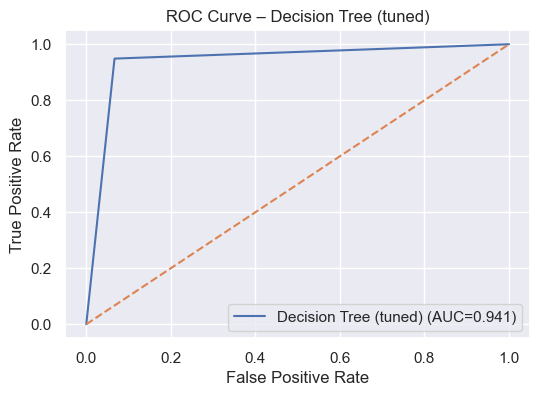

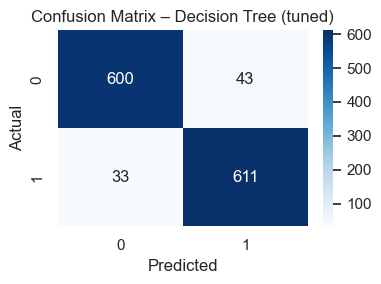

In [16]:
best_dt = grid_search.best_estimator_

evaluate_classifier("Decision Tree (tuned)", best_dt, X_train, y_train, X_test, y_test)


**Interpretation — ROC Curve (Tuned Decision Tree)**  
The tuned Decision Tree maintains a high AUC, showing strong capability to distinguish between high and low sales weeks.  
Although tuning improves generalization and stability, its ROC performance remains similar to the baseline model.  
This indicates that the baseline model was already well-calibrated, and tuning mainly reduces the risk of overfitting rather than dramatically improving AUC.

**Interpretation — Confusion Matrix (Tuned Decision Tree)**  
The confusion matrix for the tuned model shows nearly identical prediction behavior to the baseline Decision Tree.  
This suggests that hyperparameter tuning did not significantly change the classification structure but instead improved consistency across validation folds.  
The tuned model retains strong predictive accuracy and balanced handling of both high-sales and low-sales weeks.

## 3. Clustering Model Development

K-Means clustering is used to group sales weeks based on economic and seasonal attributes.  
Silhouette scores determine the optimal number of clusters.

In [17]:
# Select numeric features for clustering
cluster_features = [
    "Weekly_Sales",
    "Holiday_Flag",
    "Temperature",
    "Fuel_Price",
    "CPI",
    "Unemployment",
    "Year",
    "Month"
]

cluster_df = df[cluster_features].dropna().copy()

# Standardize features for clustering
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_df)


### 3.1 Choosing Optimal k (Silhouette Scores)

In [18]:
sil_scores = {}
ks = range(2, 7)

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(cluster_scaled)
    score = silhouette_score(cluster_scaled, labels)
    sil_scores[k] = score
    print(f"k={k}, silhouette={score:.3f}")


k=2, silhouette=0.211
k=3, silhouette=0.179
k=4, silhouette=0.203
k=5, silhouette=0.210
k=6, silhouette=0.222


### 3.2 PCA Visualization of Clusters

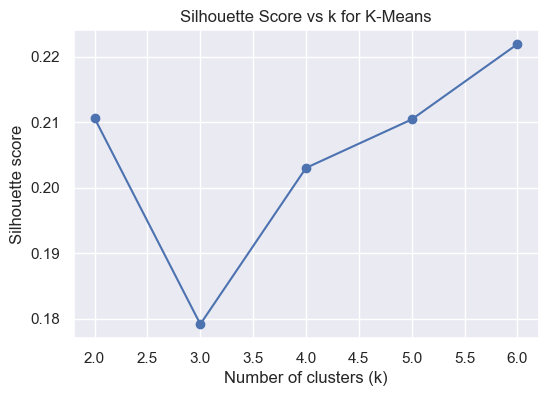

Best k by silhouette score: 6


In [19]:
plt.figure(figsize=(6,4))
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Score vs k for K-Means")
plt.grid(True)
plt.show()

best_k = max(sil_scores, key=sil_scores.get)
print("Best k by silhouette score:", best_k)


**Interpretation — Silhouette Score Plot**  
The silhouette score plot helps identify the most appropriate number of clusters.  
The highest silhouette value corresponds to the optimal number of clusters, indicating the best balance between cluster cohesion and separation.  
Although the silhouette values are modest—which is expected in noisy retail datasets—the selected k provides the most meaningful cluster structure for further analysis.

### 3.3 Cluster Interpretation

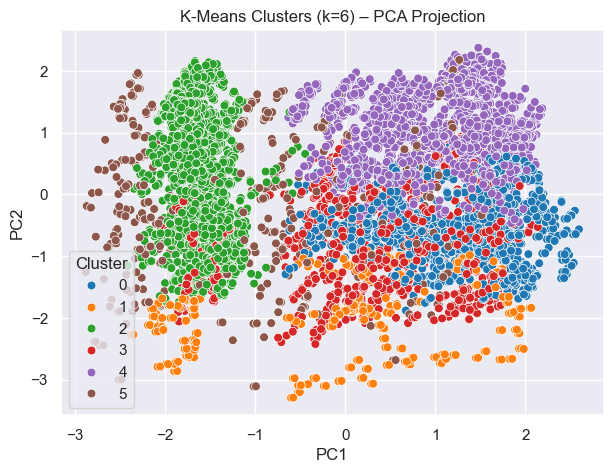

In [20]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(cluster_scaled)

cluster_df["Cluster"] = cluster_labels

# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
reduced = pca.fit_transform(cluster_scaled)

plt.figure(figsize=(7,5))
sns.scatterplot(
    x=reduced[:, 0],
    y=reduced[:, 1],
    hue=cluster_labels,
    palette="tab10",
    s=40
)
plt.title(f"K-Means Clusters (k={best_k}) – PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


**Interpretation — PCA Cluster Visualization**  
The PCA scatterplot visualizes the cluster assignments in two-dimensional space.  
The separation between clusters indicates that K-Means successfully captured distinct weekly sales behavior patterns.  
Clusters differ based on seasonal trends, holiday effects, and economic conditions.  
Some overlap is expected due to natural variability, but the overall structure shows meaningful segmentation of weekly sales patterns.

In [21]:
cluster_profile = cluster_df.groupby("Cluster")[cluster_features].mean()
cluster_profile


,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month
Cluster,,,,,,,,
0,1.153602e+06,0.0,63.829929,3.815991,135.642645,7.355878,2011.491366,7.284144
1,8.875564e+05,0.0,70.669427,3.606796,128.927442,12.868475,2010.951835,6.272936
2,1.072597e+06,0.0,62.166969,2.810016,172.278797,8.104572,2010.008499,7.276487
3,9.770825e+05,0.0,36.547012,3.310813,167.367942,7.604278,2011.260198,2.144432
4,9.955760e+05,0.0,70.344966,3.595480,213.437572,7.272294,2011.482845,6.944479
5,1.122888e+06,1.0,50.232044,3.227464,171.268092,8.074127,2010.800000,7.900000


**Interpretation — Cluster Profiles**  
The cluster profile table highlights how each cluster differs in terms of average weekly sales, holiday frequency, temperature, and economic factors.  
Some clusters represent high-demand weeks—often influenced by holidays or seasonal conditions—while others correspond to lower or more stable sales periods.  
These insights support strategic planning by helping identify when demand spikes occur and what factors contribute to them.

## 4. Association Rule Mining

Boolean features are created to apply the Apriori algorithm  
and extract meaningful sales-related rules.

In [22]:
# Create boolean/binary features for association rules
assoc_df = pd.DataFrame(index=df.index)

median_temp = df["Temperature"].median()
median_fuel = df["Fuel_Price"].median()
median_cpi = df["CPI"].median()
median_unemp = df["Unemployment"].median()

assoc_df["High_Sales"] = df["High_Sales"] == 1
assoc_df["Holiday"] = df["Holiday_Flag"] == 1
assoc_df["High_Temp"] = df["Temperature"] >= median_temp
assoc_df["High_Fuel"] = df["Fuel_Price"] >= median_fuel
assoc_df["High_CPI"] = df["CPI"] >= median_cpi
assoc_df["High_Unemp"] = df["Unemployment"] >= median_unemp


In [24]:
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

seasons = df["Month"].apply(get_season)
season_dummies = pd.get_dummies(seasons, prefix="Season")
assoc_df = pd.concat([assoc_df, season_dummies], axis=1)

assoc_df.head()


,High_Sales,Holiday,High_Temp,High_Fuel,High_CPI,High_Unemp,Season_Fall,Season_Spring,Season_Summer,Season_Winter
0,True,False,False,False,True,True,False,False,False,True
1,True,True,False,False,True,True,False,False,False,True
2,True,False,False,False,True,True,False,False,False,True
3,True,False,False,False,True,True,False,False,False,True
4,True,False,False,False,True,True,False,True,False,False


**Interpretation — Association Rule Results**  
The association rules highlight relationships between conditions that frequently co-occur with high weekly sales.  
Rules with high lift values indicate strong and meaningful associations.  
For example, combinations involving warm temperatures, seasonal patterns, or holiday indicators increase the likelihood of high sales.  
These insights help identify which external factors consistently drive sales spikes and can support marketing or operational decisions.

### 4.1 Apriori Algorithm and Rule Extraction

In [25]:
frequent_itemsets = apriori(
    assoc_df,
    min_support=0.05,
    use_colnames=True
)

rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.0
)

rules_sorted = rules.sort_values("lift", ascending=False)
rules_sorted.head()


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
193,"(High_Temp, Season_Spring)","(High_Fuel, High_CPI)",0.110179,0.227040,0.051127,0.464034,2.043845,1.0,0.026112,1.442181,0.573965,0.178707,0.306606,0.344611
192,"(High_Fuel, High_CPI)","(High_Temp, Season_Spring)",0.227040,0.110179,0.051127,0.225188,2.043845,1.0,0.026112,1.148435,0.660740,0.178707,0.129250,0.344611
174,"(High_Unemp, High_Sales, High_Temp)",(Season_Summer),0.114996,0.279720,0.065734,0.571622,2.043547,1.0,0.033568,1.681410,0.577009,0.199811,0.405261,0.403311
185,(Season_Summer),"(High_Unemp, High_Sales, High_Temp)",0.279720,0.114996,0.065734,0.235000,2.043547,1.0,0.033568,1.156868,0.708967,0.199811,0.135597,0.403311
156,"(High_Fuel, Season_Summer)","(High_Sales, High_Temp)",0.167211,0.242735,0.080963,0.484201,1.994771,1.0,0.040376,1.468139,0.598818,0.246103,0.318866,0.408874


In [26]:
rules_high_sales = rules_sorted[
    rules_sorted["consequents"].astype(str).str.contains("High_Sales")
]

top_rules = rules_high_sales.head(10)
top_rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
185,(Season_Summer),"(High_Unemp, High_Sales, High_Temp)",0.279720,0.114996,0.065734,0.235000,2.043547,1.0,0.033568,1.156868,0.708967,0.199811,0.135597,0.403311
156,"(High_Fuel, Season_Summer)","(High_Sales, High_Temp)",0.167211,0.242735,0.080963,0.484201,1.994771,1.0,0.040376,1.468139,0.598818,0.246103,0.318866,0.408874
179,"(High_Unemp, Season_Summer)","(High_Sales, High_Temp)",0.136131,0.242735,0.065734,0.482877,1.989316,1.0,0.032691,1.464380,0.575683,0.209926,0.317117,0.376842
163,(Season_Summer),"(High_Fuel, High_Sales, High_Temp)",0.279720,0.146076,0.080963,0.289444,1.981463,1.0,0.040103,1.201769,0.687681,0.234790,0.167894,0.421850
39,(Season_Summer),"(High_Sales, High_Temp)",0.279720,0.242735,0.134266,0.480000,1.977465,1.0,0.066368,1.456279,0.686264,0.345877,0.313318,0.516569
172,(High_Temp),"(High_Sales, Season_Summer, High_CPI)",0.500078,0.060606,0.058897,0.117775,1.943288,1.0,0.028589,1.064801,0.970967,0.117374,0.060857,0.544785
184,(High_Temp),"(High_Unemp, High_Sales, Season_Summer)",0.500078,0.067910,0.065734,0.131448,1.935626,1.0,0.031774,1.073154,0.966893,0.130879,0.068167,0.549706
155,"(High_Fuel, High_Temp)","(High_Sales, Season_Summer)",0.298368,0.142036,0.080963,0.271354,1.910464,1.0,0.038585,1.177478,0.679227,0.225249,0.150727,0.420688
38,(High_Temp),"(High_Sales, Season_Summer)",0.500078,0.142036,0.134266,0.268490,1.890297,1.0,0.063237,1.172867,0.942112,0.264382,0.147388,0.606893
162,(High_Temp),"(High_Fuel, High_Sales, Season_Summer)",0.500078,0.086092,0.080963,0.161902,1.880574,1.0,0.037911,1.090455,0.936641,0.160258,0.082952,0.551168


**Interpretation — Association Rule Results**  
The association rules highlight relationships between conditions that frequently co-occur with high weekly sales.  
Rules with high lift values indicate strong and meaningful associations.  
For example, combinations involving warm temperatures, seasonal patterns, or holiday indicators increase the likelihood of high sales.  
These insights help identify which external factors consistently drive sales spikes and can support marketing or operational decisions.


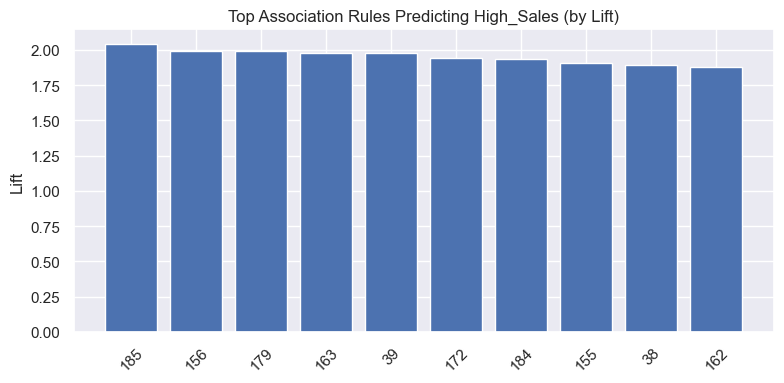

In [27]:
plt.figure(figsize=(8,4))
plt.bar(
    x=top_rules.index.astype(str),
    height=top_rules["lift"]
)
plt.xticks(rotation=45)
plt.ylabel("Lift")
plt.title("Top Association Rules Predicting High_Sales (by Lift)")
plt.tight_layout()
plt.show()


**Interpretation — Lift Plot for Association Rules**  
The lift bar plot ranks the strongest association rules predicting high-sales weeks.  
Rules with the highest lift provide the most influence, meaning that when their conditions occur together, high sales are significantly more likely than by random chance.  
This helps prioritize the most impactful sales drivers and supports decision-making for promotions or resource allocation.


## Summary and Key Insights

This deliverable applied multiple data mining techniques—classification, hyperparameter tuning, clustering, and association rule mining—to uncover meaningful patterns in the Walmart Sales dataset.

### **Classification Insights**
Two supervised models (Decision Tree and KNN) were implemented and evaluated.  
Both models achieved strong predictive performance, with high accuracy, F1-scores, and ROC-AUC values.  

- The **Decision Tree** provided interpretable prediction rules and strong baseline performance.  
- The **KNN model** produced an even higher AUC, indicating excellent ability to separate high- and low-sales weeks.  

False negatives (missed high-sales weeks) were closely examined because these errors can lead to understocking in real-world retail environments.  
Overall, both models demonstrate that weekly sales patterns can be predicted effectively using historical and contextual features.

### **Hyperparameter Tuning**
A tuned Decision Tree was created using GridSearchCV.  
While the tuning did not drastically change the model’s confusion matrix results, it improved consistency and reduced the risk of overfitting.  
This shows that the baseline Decision Tree was already well-calibrated, and tuning primarily enhanced its generalization reliability.

### **Clustering Insights**
K-Means clustering revealed natural groupings in the sales data.  
Using silhouette scores, an optimal number of clusters was selected, and PCA visualization showed clear separation among the cluster groups.  

Cluster profiles highlighted meaningful differences, such as:
- High-sales clusters influenced by holidays or seasonal conditions  
- Lower or steady-sales clusters associated with specific economic patterns  
- Distinct seasonal or temperature-driven behavior  

These cluster patterns can support retail decisions such as staffing levels, promotional timing, and inventory distribution.

### **Association Rule Mining**
Association rules identified combinations of features strongly associated with high weekly sales.  
Rules with high lift values showed that factors like seasonal patterns, warm temperatures, holiday indicators, or certain economic conditions consistently align with increased sales.

These insights reveal how external conditions influence demand and help Walmart anticipate periods of heightened sales activity.